In [1]:
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
sns.set(font=['sans-serif'])
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft JhengHei']})
from tqdm import tqdm
import zhplot
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore')
from collections import defaultdict
from plyer import notification

c:\Users\A51857\AppData\Local\anaconda3\envs\Lab01\lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.1)
  from scipy.stats import gaussian_kde


In [24]:
def send_notification(Tn,M,time):
    notification.notify(
        title=Tn,
        message=M,
        timeout=time)
def count_mdd(df_profit,window):
    Roll_Max = df_profit.rolling(window, min_periods=1).max()
    # Daily_Drawdown = df_profit/Roll_Max - 1
    Daily_Drawdown = df_profit-Roll_Max
    return Daily_Drawdown
def count_daily_exp(df,col_name='Daily_Profit'):
    mean_win = df[df[col_name]<0][col_name].mean()
    mean_lose = df[df[col_name]>0][col_name].mean()
    pl = np.where(mean_win>mean_lose,round(abs(mean_win/mean_lose),4),round(mean_win/mean_lose,4))
    win_pro = len(df[df[col_name]>0])/len(df)
    exp = round(win_pro*pl-(1-win_pro),4)
    return pl,win_pro,exp
def count_tade_exp(win_pro,pl):
    exp = round(win_pro*pl-(1-win_pro),4)
    return exp
# send_notification(Tn='提醒',M='Price Gap 資料整理完成',time=None)

### **跨越價差策略**
- 股票漲停後續走向統計
- 到期月份: 連續2個月份，再加上 3 月、6 月、9 月、12 月中3個接續季月

In [3]:
data = pd.read_csv('Data/stock_daily_beta.csv',index_col=0).sort_index(ascending=True)
data = data[data.index.isna()==False]
data.index = pd.to_datetime(data.index)
data

,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,yesterday_high,yesterday_low,tomorrow_open,tomorrow_low,Beta_Q1,Beta_Q2,Beta_Q25,Beta_Q3,Value_Q3,Daily
日期,,,,,,,,,,,,,,,,,,,,,
2020-09-01,9945.0,潤泰新,43.05,43.05,41.65,41.85,-1.35,-3.13,3.24,10638.0,...,NaN,NaN,42.05,41.15,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,2540.0,愛山林,48.70,50.60,48.00,50.00,1.50,3.09,5.36,205.0,...,NaN,NaN,50.00,49.90,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,2539.0,櫻花建,31.95,31.95,31.30,31.55,-0.40,-1.25,2.03,339.0,...,NaN,NaN,31.65,31.10,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,2515.0,中工,8.19,8.23,8.12,8.16,-0.01,-0.12,1.35,6437.0,...,NaN,NaN,8.20,8.03,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,2504.0,國產,22.10,22.45,21.00,21.25,-0.40,-1.85,6.70,24773.0,...,NaN,NaN,21.15,20.90,-17.585,-4.88,-4.88,6.25,564.65,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,2439.0,美律,113.50,113.50,112.00,112.50,0.00,0.00,1.33,1469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17,2440.0,太空梭,13.40,13.90,13.30,13.80,0.55,4.15,4.53,378.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17,2441.0,超豐,56.80,56.90,56.20,56.30,0.00,0.00,1.24,454.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data[data['漲跌停']!=0]

,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,yesterday_high,yesterday_low,tomorrow_open,tomorrow_low,Beta_Q1,Beta_Q2,Beta_Q25,Beta_Q3,Value_Q3,Daily
日期,,,,,,,,,,,,,,,,,,,,,
2020-09-01,8046.0,南電,121.00,132.50,117.00,132.50,12.00,9.96,12.86,41592.0,...,NaN,NaN,133.50,128.00,-17.585,-4.88,-4.88,6.2500,564.65,1.0
2020-09-03,1802.0,台玻,11.55,12.35,11.25,12.35,1.10,9.78,9.78,51153.0,...,11.55,11.2,12.00,11.95,-5.485,0.00,0.00,10.2925,556.60,1.0
2020-09-03,2409.0,友達,11.30,11.85,11.25,11.85,1.05,9.72,5.56,667023.0,...,10.85,10.5,11.55,11.50,-5.485,0.00,0.00,10.2925,556.60,1.0
2020-09-03,3661.0,世芯-KY,536.00,581.00,530.00,581.00,52.00,9.83,9.64,7165.0,...,558.00,529.0,563.00,542.00,-5.485,0.00,0.00,10.2925,556.60,1.0
2020-09-04,5269.0,祥碩,1630.00,1645.00,1525.00,1525.00,-165.00,-9.76,7.10,1987.0,...,1735.00,1680.0,1535.00,1375.00,-8.170,0.00,0.00,8.6675,560.80,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,7722.0,LINEPAY,567.00,621.00,567.00,621.00,56.00,9.91,9.56,596.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17,6412.0,群電,114.00,124.00,113.00,124.00,11.00,9.73,9.73,4053.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17,1616.0,億泰,39.60,41.25,39.45,41.25,3.75,10.00,4.80,12950.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
marketdates = data.groupby(data.index).first().index.to_list()
df_event = data[(data['漲跌停']!=0)&(data.index<=marketdates[-21])]
df_result = pd.DataFrame()
tp = 0
fp = 0
fn = 0
tn = 0
for i in range(len(df_event)):
    row = df_event.iloc[i]
    stock = row['股票代號']
    event_date = row.name
    position = row['漲跌停']
    price = row['收盤價']
    month1_date = marketdates[marketdates.index(event_date)+20]
    # month2_date = marketdates[marketdates.index(event_date)+40]
    try:
        price1 = data.loc[(data.index==month1_date)&(data['股票代號']==stock)]['收盤價'].values[0]
    except:
        price1=price
    # price2 = data.loc[(data.index==month2_date)&(data['股票代號']==stock)]['收盤價'].values[0]

    if (position==1) and  (price1-price)>0:
        tp+=1
    elif (position==1)  and  (price1-price)<0:
        fp+=1
    elif (position==-1) and  (price1-price)>0:
        fn+=1
    elif (position==-1) and  (price1-price)<0:
        tn+=1
total = tp+fp+fn+tn
df_result.loc["+1","+1"] = round(tp/total*100,3)
df_result.loc["+1","-1"] = round(fp/total*100,3)
df_result.loc["-1","+1"] = round(fn/total*100,3)
df_result.loc["-1","-1"] = round(tn/total*100,3)
df_result

,+1,-1
+1,35.233,17.995
-1,34.249,12.523


In [6]:
df_event_daily = df_event.groupby(df_event.index)['股票代號'].apply(list).to_frame()
df_event_daily['Num'] = df_event_daily['股票代號'].apply(lambda x: len(x))
print('Max :' + str(df_event_daily['Num'].max()) +' ,Mean : ' +str(int(df_event_daily['Num'].mean())))

Max :932 ,Mean : 6


In [7]:
# 股期近月
df_near = pd.read_csv('Data/stockfuture_daily.csv',index_col=0).sort_index(ascending=True)
df_near.index = pd.to_datetime(df_near.index)
# 股期遠月(次月)
df_far = pd.read_csv('Data/stockfuture_daily_far.csv',index_col=0).sort_index(ascending=True)
df_far.index = pd.to_datetime(df_far.index)
df_far['代號'] = [i[:-1] for i in df_far['代號']]

In [8]:
# df_future = pd.DataFrame(columns = ['日期','代號','名稱','近月開盤價','近月最高價','近月最低價','近月收盤價','遠月開盤價','遠月高盤價','遠月最低價','遠月收盤價'])
# for i in tqdm(range(len(df_near))):
#     row = df_near.iloc[i]
#     pid = row['代號']
#     date = row.name
#     stock = row['名稱'][:-4]
#     near_O = row['開盤價']
#     near_H = row['最高價']
#     near_L = row['最低價']
#     near_C = row['收盤價']
#     far_row = df_far.loc[(df_far.index==date)&(df_far['代號']==pid)]
#     try:
#         far_O = far_row['開盤價'].values[0]
#         far_H = far_row['最高價'].values[0]
#         far_L = far_row['最低價'].values[0]
#         far_C = far_row['收盤價'].values[0]
#     except:
#         far_O = np.nan
#         far_H = np.nan
#         far_L = np.nan
#         far_C = np.nan
#     new_row = [date,pid,stock,near_O,near_H,near_L,near_C,far_O,far_H,far_L,far_C]
#     df_future.loc[i] = new_row
df_future = pd.read_csv('Data/stockfuture_clean.csv',index_col=0)
df_future = df_future.set_index('日期')
df_future.index = pd.to_datetime(df_future.index)
df_future['前日遠月收盤價'] = df_future.groupby('代號')['遠月收盤價'].shift(1)
df_future['前日近月收盤價'] = df_future.groupby('代號')['近月收盤價'].shift(1)
df_future['近月停損'] = df_future['近月收盤價'].shift(7)*(1-0.2)
df_future['遠月停損'] = df_future['遠月收盤價'].shift(7)*(1-0.2)
df_future['Gap'] = ((df_future['近月收盤價'] - df_future['遠月收盤價'])/df_future['近月收盤價'])
# df_future['Gap_Roll60'] = df_future.groupby('代號')['Gap'].mean()
# df_future['Gap_fix'] = df_future['Gap'] - df_future['Gap_Roll60']

In [9]:
future_pid = pd.read_csv('Data/stockfuture_pid.csv')
for i in tqdm(future_pid['代號']):
    pid = future_pid[future_pid['代號']==i]['標的代號'].values[0]
    if str(pid).isnumeric()==True:
        df_future.loc[df_future['代號']==i,'股票代號'] = float(pid)
    else:
        df_future.loc[df_future['代號']==i,'股票代號'] = np.nan
df_future = df_future.dropna()
df_future

100%|██████████| 290/290 [00:04<00:00, 68.20it/s]


,代號,名稱,近月開盤價,近月最高價,近月最低價,近月收盤價,遠月開盤價,遠月最高價,遠月最低價,遠月收盤價,前日遠月收盤價,前日近月收盤價,近月停損,遠月停損,Gap,股票代號
日期,,,,,,,,,,,,,,,,
2020-01-03,GCF,鴻準,66.9,67.20,66.40,66.80,66.7,67.0,66.40,66.40,66.50,66.60,58.000,58.000,0.005988,2354.0
2020-01-03,GHF,技嘉,50.2,50.40,49.60,49.95,50.2,50.4,49.80,49.90,49.95,50.20,7.808,7.792,0.001001,2376.0
2020-01-03,GIF,微星,89.3,90.50,88.20,89.30,90.3,90.3,88.10,88.90,88.90,89.10,18.320,18.320,0.004479,2377.0
2020-01-03,GNF,凌陽,13.7,13.70,13.20,13.35,13.7,13.7,13.30,13.35,13.80,13.80,16.600,16.600,0.000000,2401.0
2020-01-03,GLF,正崴,46.1,46.15,44.75,45.60,46.0,46.0,44.65,45.50,45.95,46.15,139.200,140.000,0.002193,2392.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-02,PRF,宏捷科,76.3,77.50,73.30,74.00,74.0,74.0,74.00,74.00,77.30,77.30,602.400,600.000,0.000000,8086.0
2025-06-02,PSF,神達,58.2,59.40,57.30,59.30,57.4,59.2,57.40,58.90,59.90,59.80,29.520,28.960,0.006745,3706.0
2025-06-02,PTF,雙鴻,558.0,560.00,547.00,558.00,568.0,568.0,568.00,568.00,563.00,569.00,16.280,16.240,-0.017921,3324.0


100%|██████████| 2760/2760 [00:03<00:00, 696.87it/s]


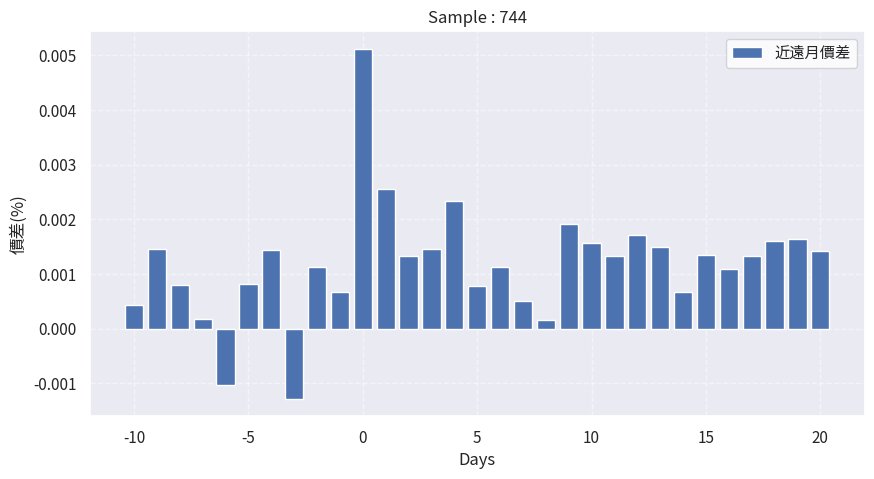

In [10]:
backward_days = 10
forward_days = 20
df_sp = data[data['漲跌停']==1]
df_event_result = pd.DataFrame(index=list(range(-backward_days,forward_days+1)))
for i in tqdm(range(len(df_sp))):
    row = df_sp.iloc[i]
    stock = row['股票代號']
    date = row.name
    if marketdates.index(date)>=backward_days and marketdates.index(date)+forward_days<len(marketdates):
        start_date = marketdates[marketdates.index(date)-backward_days]
        end_date = marketdates[marketdates.index(date)+forward_days]
        window = df_future.loc[(df_future['股票代號']==stock)&(df_future.index>=start_date)&(df_future.index<=end_date)]['Gap'].values
        if len(window)==(forward_days+backward_days+1):
            df_event_result[i] = window
df_event_result['Mean'] = df_event_result.mean(axis=1)
plt.figure(figsize=(10,5))
plt.title(f'Sample : {len(df_event_result.columns[:-1])}')
plt.xlabel('Days')
plt.ylabel('價差(%)')
plt.grid(True,alpha=0.5,linestyle = '--')
plt.bar(df_event_result.index,df_event_result['Mean'],label='近遠月價差')
# plt.plot(df_event_result['CAR']*100,label='CAR',color='C01')
plt.legend(facecolor='white')

### **Strategy**
- 方法: 股票遇到漲停，假設期貨收斂，所以做空高者(近月)並做多低者(遠月)
- 檢驗: 買得到漲停還是買不到
- Long only 檢驗long近月跟long遠月的差異


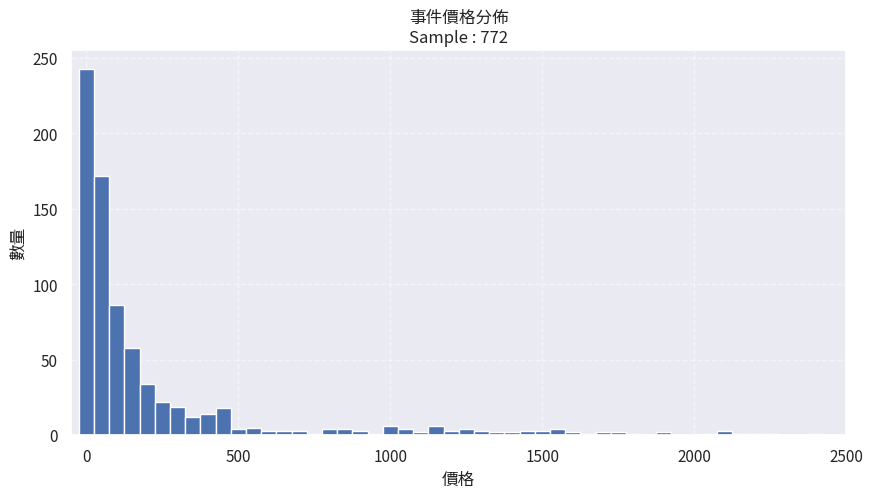

In [11]:
def count_price_group(df_event,df_all_price,price_step=50):
    '''
    df_event : DataFrame , which contain goods and dates that trigger event.
    df_all_price : DataFrame, which contain daily open of every stock.
    price_step : int, price range that each group contain.
    '''
    df_price = pd.DataFrame()
    for i in range(len(df_event)):
        row = df_event.iloc[i]
        stock = row['股票代號']
        buydate = row.name
        buy_statu =  df_all_price.loc[(df_all_price['股票代號']==stock)&(df_all_price.index==buydate)]
        if len(buy_statu)!=0:
            if (buy_statu['Gap'].values[0]<0):
                long_side = '近月'
            else:
                long_side = '遠月'
            buyprice = buy_statu[long_side+'開盤價'].values[0]
            df_price.loc[len(df_price),'Price']=buyprice
    df_price_group = df_price.groupby(pd.cut(df_price['Price'],np.arange(0,2500,price_step))).count()
    plt.figure(figsize=(10,5))
    plt.title(f'事件價格分佈\nSample : {len(df_price)}')
    plt.xlabel('價格')
    plt.ylabel('數量')
    plt.xlim([-price_step,2500])
    plt.grid(True,alpha=0.5,linestyle = '--')
    plt.bar(np.arange(0,2500-price_step,price_step),df_price_group['Price'],width=50)
count_price_group(df_sp,df_future)

In [12]:
df_future[df_future.index=='2025-04-11']

,代號,名稱,近月開盤價,近月最高價,近月最低價,近月收盤價,遠月開盤價,遠月最高價,遠月最低價,遠月收盤價,前日遠月收盤價,前日近月收盤價,近月停損,遠月停損,Gap,股票代號
日期,,,,,,,,,,,,,,,,
2025-04-11,IJF,大立光,1900.00,2025.00,1900.00,2025.00,1905.00,2030.00,1905.00,2030.00,1810.00,1810.00,13.920,12.720,-0.002469,3008.0
2025-04-11,IMF,亞光,119.00,129.00,113.00,129.00,116.00,129.00,113.00,129.00,120.00,120.00,116.800,106.000,0.000000,3019.0
2025-04-11,IOF,聯詠,498.00,508.00,484.00,504.00,499.00,506.00,498.50,505.00,504.00,503.00,1168.000,1168.000,-0.001984,3034.0
2025-04-11,IPF,智原,189.50,201.00,175.50,200.00,185.50,200.50,177.00,200.00,190.00,190.50,29.920,30.120,0.000000,3035.0
2025-04-11,IQF,文曄,86.00,89.30,84.00,89.00,87.50,89.10,86.50,89.10,88.50,88.50,33.920,33.600,-0.001124,3036.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-11,PMF,大江,142.00,142.00,137.00,137.00,140.50,140.50,140.00,140.00,132.50,146.00,25.744,25.768,-0.021898,8436.0
2025-04-11,PPF,宣德,36.70,37.05,36.50,37.05,38.45,38.45,38.45,38.45,37.65,37.40,1104.000,1120.000,-0.037787,5457.0
2025-04-11,PQF,金居,41.20,42.60,39.15,42.30,40.75,41.35,40.50,41.35,42.00,42.40,1712.000,1752.000,0.022459,8358.0


In [17]:
amount = 5000000
result = []
df_daily_group = df_sp.groupby(df_sp.index)['股票代號'].apply(list).to_frame()
# for i in tqdm(range(len(df_daily_group))):
#     date = df_daily_group.iloc[i].name
#     group = df_daily_group.iloc[i]['股票代號']
#     date_statu = df_future[(df_future['股票代號'].isin(group))&(df_future.index==date)].sort_values('近月開盤價',ascending=False)['股票代號']
#     if len(date_statu)>=10:
#         group=date_statu.to_list()[:5]
#         print(date,group)
#     result.append({
#         '日期': date,
#         '股票代號': group
#     })
# df_daily_group = pd.DataFrame(result).set_index('日期',drop=True)
df_daily_group['Num'] = [len(i) for i in df_daily_group['股票代號']]
df_daily_group

,股票代號,Num
日期,,
2020-09-01,[8046.0],1
2020-09-03,"[1802.0, 2409.0, 3661.0]",3
2020-09-07,"[2303.0, 1609.0]",2
2020-09-10,"[1802.0, 1513.0, 4763.0]",3
2020-09-11,[2540.0],1
...,...,...
2025-06-10,"[1533.0, 3013.0, 2374.0, 2429.0, 2427.0, 2467....",10
2025-06-11,"[4949.0, 3189.0, 6901.0, 8478.0, 6451.0, 6805....",10
2025-06-12,"[1616.0, 2468.0, 6230.0, 6552.0, 6674.0, 6890.0]",6


In [18]:
def backtest(n,way,long_n,short_n,stoploss=1):
    df_profit = pd.DataFrame(index=marketdates)
    df_delta = pd.DataFrame(index=marketdates)
    df_bytrade_total = pd.DataFrame()
    df_bytrade_long = pd.DataFrame()
    df_bytrade_short = pd.DataFrame()
    df_bytrade_longnear = pd.DataFrame()
    df_bytrade_longfar = pd.DataFrame()
    df_profit_longnear = pd.DataFrame(index=marketdates)
    df_profit_longfar = pd.DataFrame(index=marketdates)
    fee=12
    stoploss_times=0
    far_times=0
    near_times=0

    for i in tqdm(range(len(df_sp))):
        row = df_sp.iloc[i]
        stock = row['股票代號']
        date = row.name
        amount_per = amount/df_daily_group.loc[date,'Num']
        if marketdates.index(date)+1<len(marketdates):
            tomorrow = marketdates[marketdates.index(date)+1]
        else:
            tomorrow = marketdates[-1]
        if marketdates.index(date)+n<len(marketdates):
            end_date = marketdates[marketdates.index(date)+n]
        else:
            end_date = marketdates[-1]
        date_statu = df_future.loc[(df_future['股票代號']==stock)&(df_future.index==date)]
        # end_statu = df_future.loc[(df_future['股票代號']==stock)&(df_future.index==end_date)]
        window = df_future.loc[(df_future['股票代號']==stock)&(df_future.index>=date)&(df_future.index<=end_date)]
        if len(window)!=0:
            if (date_statu.loc[date]['Gap']<0):
                long_side = '近月'
                short_side = '遠月'
            else:
                long_side = '遠月'
                short_side = '近月'
            if way=='Close_Uncondition':
                # 當天收盤買進(不論能否成交)
                if long_side=='遠月':
                    far_times +=1
                else:
                    near_times+=1
                if len(window[window[long_side+'最低價']<window.loc[date,long_side+'收盤價']*(1-stoploss)])!=0:
                    stoploss_times+=1
                    stop_date = window[window[long_side+'最低價']<window.loc[date,long_side+'收盤價']*(1-stoploss)].index[0]
                    window = window[:stop_date]
                    window.loc[stop_date,long_side+'收盤價'] = window.iloc[0][long_side+'收盤價']*(1-stoploss)
                else:
                    stop_date = window.index[-1]
                num_long = int(amount_per/(window.loc[date][long_side+'收盤價']*2000))
                num_short = int(amount_per/(window.loc[date][short_side+'收盤價']*2000))
                if num_long>0 and num_short:
                    long = (window[long_side+'收盤價'] - window.loc[date][long_side+'收盤價'])*2000*num_long - num_long*fee
                    short = (-window[short_side+'收盤價'] + window.loc[date][short_side+'收盤價'])*2000*num_short - num_short*fee
                    delta = window[long_side+'收盤價']*2000*num_long
                    df_profit[str(stock)+str(i)+'_Long'] = long
                    df_profit[str(stock)+str(i)+'_Short'] = short
                    df_delta[str(stock)+str(i)] = delta
                    df_bytrade_total.loc[len(df_bytrade_total),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'收盤價'])*2000*num_long-num_long*fee+(window.iloc[0][short_side+'收盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short-num_short*fee
                    df_bytrade_long.loc[len(df_bytrade_long),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'收盤價'])*2000*num_long - num_long*fee
                    df_bytrade_short.loc[len(df_bytrade_short),'Trade_Profit'] = (window.iloc[0][short_side+'收盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short - num_short*fee
                # Long 近月 Compare 
                num_longnear =  int(amount_per/(window.loc[date]['近月收盤價']*2000))
                if num_longnear>0:
                    df_profit_longnear[str(stock)+str(i)+'_Compare'] = (window['近月收盤價'] - window.loc[date]['近月收盤價'])*2000*num_longnear - num_longnear*fee
                    df_bytrade_longnear.loc[len(df_bytrade_longnear),'Trade_Profit'] = (window.iloc[-1]['近月收盤價']-window.iloc[0]['近月收盤價'])*2000*num_longnear - num_longnear*fee
                # Long 遠月 Compare
                num_longfar = int(amount_per/(window.loc[date]['遠月收盤價']*2000))
                if num_longfar>0:
                    df_profit_longfar[str(stock)+str(i)+'_Compare'] = (window['遠月收盤價'] - window.loc[date]['遠月收盤價'])*2000*num_longfar - num_longfar*fee
                    df_bytrade_longfar.loc[len(df_bytrade_longfar),'Trade_Profit'] = (window.iloc[-1]['遠月收盤價']-window.iloc[0]['遠月收盤價'])*2000*num_longfar - num_longfar*fee
            if way=='Close':
                # 當天收盤買進
                if (window.loc[date][long_side+'收盤價']!=window.loc[date][long_side+'最高價'])&(window.loc[date][long_side+'收盤價']<window.loc[date]['前日'+long_side+'收盤價']*1.095):
                    if long_side=='遠月':
                        far_times +=1
                    else:
                        near_times+=1
                    if len(window[window[long_side+'最低價']<window.loc[date,long_side+'收盤價']*(1-stoploss)])!=0:
                        stoploss_times+=1
                        stop_date = window[window[long_side+'最低價']<window.loc[date,long_side+'收盤價']*(1-stoploss)].index[0]
                        window = window[:stop_date]
                        window.loc[stop_date,long_side+'收盤價'] = window.iloc[0][long_side+'收盤價']*(1-stoploss)
                    else:
                        stop_date = window.index[-1]
                    # window = window[:stop_date]
                    
                    num_long = int(amount_per/(window.loc[date][long_side+'收盤價']*2000))
                    num_short = int(amount_per/(window.loc[date][short_side+'收盤價']*2000))
                    if num_long>0 and num_short>0:
                        long = (window[long_side+'收盤價'] - window.loc[date][long_side+'收盤價'])*2000*num_long - num_long*fee
                        short = (-window[short_side+'收盤價'] + window.loc[date][short_side+'收盤價'])*2000*num_short - num_short*fee
                        delta = window[long_side+'收盤價']*2000*num_long
                        df_profit[str(stock)+str(i)+'_Long'] = long
                        df_profit[str(stock)+str(i)+'_Short'] = short
                        df_delta [str(stock)+str(i)] = delta
                        df_bytrade_total.loc[len(df_bytrade_total),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'收盤價'])*2000*num_long-num_long*fee+(window.iloc[0][short_side+'收盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short-num_short*fee
                        df_bytrade_long.loc[len(df_bytrade_long),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'收盤價'])*2000*num_long-num_long*fee
                        df_bytrade_short.loc[len(df_bytrade_short),'Trade_Profit'] = (window.iloc[0][short_side+'收盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short-num_short*fee
                # Long 近月 Compare   
                if (window.loc[date]['近月收盤價']!=window.loc[date]['近月最高價'])&(window.loc[date]['近月收盤價']<window.loc[date]['前日近月收盤價']*1.095):
                    num_longnear =  int(amount_per/(window.loc[date]['近月收盤價']*2000))
                    if num_longnear>0:
                        df_profit_longnear[str(stock)+str(i)+'_Compare'] = (window['近月收盤價'] - window.loc[date]['近月收盤價'])*2000*num_longnear - num_longnear*fee
                        df_bytrade_longnear.loc[len(df_bytrade_longnear),'Trade_Profit'] = (window.iloc[-1]['近月收盤價']-window.iloc[0]['近月收盤價'])*2000*num_longnear - num_longnear*fee
                # Long 遠月 Compare 
                if (window.loc[date]['遠月收盤價']!=window.loc[date]['遠月最高價'])&(window.loc[date]['遠月收盤價']<window.loc[date]['前日遠月收盤價']*1.095):
                    num_longfar =  int(amount_per/(window.loc[date]['遠月收盤價']*2000))
                    if num_longfar>0:
                        df_profit_longfar[str(stock)+str(i)+'_Compare'] = (window['遠月收盤價'] - window.loc[date]['遠月收盤價'])*2000*num_longfar - num_longfar*fee
                        df_bytrade_longfar.loc[len(df_bytrade_longfar),'Trade_Profit'] = (window.iloc[-1]['遠月收盤價']-window.iloc[0]['遠月收盤價'])*2000*num_longfar - num_longfar*fee
            if way=='Open':
                # 隔天開盤買進
                if long_side=='遠月':
                    far_times +=1
                else:
                    near_times+=1
                window=window.loc[tomorrow:]
                if len(window[window[long_side+'最低價']<window.loc[tomorrow,long_side+'收盤價']*(1-stoploss)])!=0:
                    stoploss_times+=1
                    stop_date = window[window[long_side+'最低價']<window.loc[tomorrow,long_side+'收盤價']*(1-stoploss)].index[0]
                    window = window[:stop_date]
                    window.loc[stop_date,long_side+'收盤價'] = window.iloc[0][long_side+'收盤價']*(1-stoploss)
                else:
                    stop_date = window.index[-1]
                # window = window[:stop_date]
                num_long = int(amount_per/(window.loc[tomorrow][long_side+'開盤價']*2000))
                num_short = int(amount_per/(window.loc[tomorrow][short_side+'開盤價']*2000))
                if num_long>0 and num_short>0:
                    long = (window[long_side+'收盤價'] - window.loc[tomorrow][long_side+'開盤價'])*2000*num_long - num_long*fee
                    short = (-window[short_side+'收盤價'] + window.loc[tomorrow][short_side+'開盤價'])*2000*num_short - num_short*fee
                    delta = window[long_side+'收盤價']*2000*num_long
                    df_profit[str(stock)+str(i)+'_Long'] = long
                    df_profit[str(stock)+str(i)+'_Short'] = short
                    df_delta [str(stock)+str(i)] = delta
                    df_bytrade_total.loc[len(df_bytrade_total),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'開盤價'])*2000*num_long-num_long*fee+(window.iloc[0][short_side+'開盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short - num_short*fee
                    df_bytrade_long.loc[len(df_bytrade_long),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'開盤價'])*2000*num_long - num_long*fee
                    df_bytrade_short.loc[len(df_bytrade_short),'Trade_Profit'] = (window.iloc[0][short_side+'開盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short - num_short*fee
                # Long 近月 Compare
                num_longnear =  int(amount_per/(window.loc[tomorrow]['近月開盤價']*2000))  
                if num_longnear>0:
                    df_profit_longnear[str(stock)+str(i)+'_Compare'] = (window['近月收盤價'] - window.loc[tomorrow]['近月開盤價'])*2000*num_longnear - num_longnear*fee
                    df_bytrade_longnear.loc[len(df_bytrade_longnear),'Trade_Profit'] = (window.iloc[-1]['近月收盤價']-window.iloc[0]['近月開盤價'])*2000*num_longnear - num_longnear*fee
                # Long 遠月 Compare
                num_longfar = int(amount_per/(window.loc[tomorrow]['遠月開盤價']*2000))
                if num_longfar>0:
                    df_profit_longfar[str(stock)+str(i)+'_Compare'] = (window['遠月收盤價'] - window.loc[tomorrow]['遠月開盤價'])*2000*num_longfar - num_longfar*fee
                    df_bytrade_longfar.loc[len(df_bytrade_longfar),'Trade_Profit'] = (window.iloc[-1]['遠月收盤價']-window.iloc[0]['遠月開盤價'])*2000*num_longfar - num_longfar*fee
            if way == 'Mix':
                ## 當天收盤買進，若漲停則隔日開盤買進
                if long_side=='遠月':
                    far_times +=1
                else:
                    near_times+=1
                if (window.loc[date][long_side+'收盤價']!=window.loc[date][long_side+'最高價'])&(window.loc[date][long_side+'收盤價']<window.loc[date]['前日'+long_side+'收盤價']*1.095):
                    if len(window[window[long_side+'最低價']<window.loc[date,long_side+'收盤價']*(1-stoploss)])!=0:
                        stoploss_times+=1
                        stop_date = window[window[long_side+'最低價']<window.loc[date,long_side+'收盤價']*(1-stoploss)].index[0]
                        window = window[:stop_date]
                        window.loc[stop_date,long_side+'收盤價'] = window.iloc[0][long_side+'收盤價']*(1-stoploss)
                    else:
                        stop_date = window.index[-1]
                    # window = window[:stop_date]
                    num_long = int(amount_per/(window.loc[date][long_side+'收盤價']*2000))
                    num_short = int(amount_per/(window.loc[date][short_side+'收盤價']*2000))
                    if num_long>0 and num_short>0:
                        long = (window[long_side+'收盤價'] - window.loc[date][long_side+'收盤價'])*2000*num_long - fee*num_long
                        short = (-window[short_side+'收盤價'] + window.loc[date][short_side+'收盤價'])*2000*num_short - fee*num_short
                        delta = window[long_side+'收盤價']*2000*num_long
                        df_bytrade_total.loc[len(df_bytrade_total),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'收盤價'])*2000*num_long-num_long*fee+(window.iloc[0][short_side+'收盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short-num_short*fee
                        df_bytrade_long.loc[len(df_bytrade_long),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'收盤價'])*2000*num_long - num_long*fee
                        df_bytrade_short.loc[len(df_bytrade_short),'Trade_Profit'] = (window.iloc[0][short_side+'收盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short - num_short*fee
                        df_profit[str(stock)+str(i)+'_Long'] = long
                        df_profit[str(stock)+str(i)+'_Short'] = short
                        df_delta [str(stock)+str(i)] = delta
                else:
                    window=window.loc[tomorrow:]
                    if len(window[window[long_side+'最低價']<window.loc[tomorrow,long_side+'收盤價']*(1-stoploss)])!=0:
                        stoploss_times+=1
                        stop_date = window[window[long_side+'最低價']<window.loc[tomorrow,long_side+'收盤價']*(1-stoploss)].index[0]
                        window = window[:stop_date]
                        window.loc[stop_date,long_side+'收盤價'] = window.iloc[0][long_side+'收盤價']*(1-stoploss)
                    else:
                        stop_date = window.index[-1]
                    # window = window[:stop_date]
                    num_long = int(amount_per/(window.loc[tomorrow][long_side+'開盤價']*2000))
                    num_short = int(amount_per/(window.loc[tomorrow][short_side+'開盤價']*2000))
                    if num_long>0 and num_short>0:
                        long = (window[long_side+'收盤價'] - window.loc[tomorrow][long_side+'開盤價'])*2000*num_long - num_long*fee
                        short = (-window[short_side+'收盤價'] + window.loc[tomorrow][short_side+'開盤價'])*2000*num_short - num_short*fee
                        delta = window[long_side+'收盤價']*2000*num_long
                        df_bytrade_total.loc[len(df_bytrade_total),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'開盤價'])*2000*num_long-num_long*fee+(window.iloc[0][short_side+'開盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short-num_short*fee
                        df_bytrade_long.loc[len(df_bytrade_long),'Trade_Profit'] = (window.iloc[-1][long_side+'收盤價']-window.iloc[0][long_side+'開盤價'])*2000*num_long-num_long*fee
                        df_bytrade_short.loc[len(df_bytrade_short),'Trade_Profit'] = (window.iloc[0][short_side+'開盤價']-window.iloc[-1][short_side+'收盤價'])*2000*num_short-num_short*fee
                        df_profit[str(stock)+str(i)+'_Long'] = long
                        df_profit[str(stock)+str(i)+'_Short'] = short
                        df_delta [str(stock)+str(i)] = delta
                # Long 近月 Compare
                window = df_future.loc[(df_future['股票代號']==stock)&(df_future.index>=date)&(df_future.index<=end_date)]
                if (window.loc[date]['近月收盤價']!=window.loc[date]['近月最高價'])&(window.loc[date]['近月收盤價']<window.loc[date]['前日近月收盤價']*1.095):
                    num_longnear =  int(amount_per/(window.loc[date]['近月收盤價']*2000))  
                    if num_longnear>0:
                        df_profit_longnear[str(stock)+str(i)+'_Compare'] = (window['近月收盤價'] - window.loc[date]['近月收盤價'])*2000*num_longnear - num_longnear*fee
                        df_bytrade_longnear.loc[len(df_bytrade_longnear),'Trade_Profit'] = (window.iloc[-1]['近月收盤價']-window.iloc[0]['近月收盤價'])*2000*num_longnear - num_longnear*fee
                else:
                    num_longnear =  int(amount_per/(window.loc[tomorrow]['近月開盤價']*2000))  
                    if num_longnear>0:
                        df_profit_longnear[str(stock)+str(i)+'_Compare'] = (window['近月收盤價'] - window.loc[tomorrow]['近月開盤價'])*2000*num_longnear - num_longnear*fee
                        df_bytrade_longnear.loc[len(df_bytrade_longnear),'Trade_Profit'] = (window.iloc[-1]['近月收盤價']-window.iloc[0]['近月開盤價'])*2000*num_longnear - num_longnear*fee
                # Long 遠月 Compare  
                window = df_future.loc[(df_future['股票代號']==stock)&(df_future.index>=date)&(df_future.index<=end_date)]
                if (window.loc[date]['遠月收盤價']!=window.loc[date]['遠月最高價'])&(window.loc[date]['遠月收盤價']<window.loc[date]['前日遠月收盤價']*1.095):
                    num_longfar = int(amount_per/(window.loc[date]['遠月收盤價']*2000))
                    if num_longfar>0:
                        df_profit_longfar[str(stock)+str(i)+'_Compare'] = (window['遠月收盤價'] - window.loc[date]['遠月收盤價'])*2000*num_longfar - num_longfar*fee
                        df_bytrade_longfar.loc[len(df_bytrade_longfar),'Trade_Profit'] = (window.iloc[-1]['遠月收盤價']-window.iloc[0]['遠月收盤價'])*2000*num_longfar - num_longfar*fee
                else:
                    num_longfar = int(amount_per/(window.loc[tomorrow]['遠月開盤價']*2000))
                    if num_longfar>0:
                        df_profit_longfar[str(stock)+str(i)+'_Compare'] = (window['遠月收盤價'] - window.loc[tomorrow]['遠月開盤價'])*2000*num_longfar - num_longfar*fee
                        df_bytrade_longfar.loc[len(df_bytrade_longfar),'Trade_Profit'] = (window.iloc[-1]['遠月收盤價']-window.iloc[0]['遠月開盤價'])*2000*num_longfar - num_longfar*fee
    print(f'遠月進場次數:{far_times},近月進場次數:{near_times}')
    df_profit = df_profit.fillna(method='ffill')
    df_profit = df_profit.fillna(0)
    df_delta = df_delta.fillna(0)
    df_delta['Delta'] = df_delta.sum(axis=1)
    df_profit_longnear = df_profit_longnear.fillna(method='ffill')
    df_profit_longnear = df_profit_longnear.fillna(0)
    df_profit_longfar = df_profit_longfar.fillna(method='ffill')
    df_profit_longfar = df_profit_longfar.fillna(0)
    df_profit['Profit'] = df_profit.sum(axis=1)
    df_profit['Daily_Profit'] = df_profit['Profit'] - df_profit['Profit'].shift(1)
    df_profit['Mdd'] = count_mdd(df_profit['Profit'],len(df_profit))
    long_columns = df_profit.columns[df_profit.columns.str.contains('Long')]
    short_columns = df_profit.columns[df_profit.columns.str.contains('Short')]
    df_long = df_profit[long_columns]
    df_short = df_profit[short_columns]
    df_long['LongOnly'] = df_long.sum(axis=1)
    df_long['Daily_Profit'] = df_long['LongOnly']-df_long['LongOnly'].shift(1)
    df_long['Mdd'] = count_mdd(df_long['LongOnly'],len(df_long))
    df_short['ShortOnly'] = df_short.sum(axis=1)
    df_short['Daily_Profit'] = df_short['ShortOnly'] - df_short['ShortOnly'].shift(1)
    df_short['Mdd'] = count_mdd(df_short['ShortOnly'],len(df_short))
    df_profit_longnear['LongNear'] = df_profit_longnear.sum(axis=1)
    df_profit_longnear['Daily_Profit'] = df_profit_longnear['LongNear'] - df_profit_longnear['LongNear'].shift(1)
    df_profit_longnear['Mdd'] = count_mdd(df_profit_longnear['LongNear'],len(df_profit_longnear))
    df_profit_longfar['LongFar'] = df_profit_longfar.sum(axis=1)
    df_profit_longfar['Daily_Profit'] = df_profit_longfar['LongFar'] - df_profit_longfar['LongFar'].shift(1)
    df_profit_longfar['Mdd'] = count_mdd(df_profit_longfar['LongFar'],len(df_profit_longfar))
    df_profit = df_profit[df_profit['Profit']!=0]
    return df_profit,df_delta,df_long,df_short,df_profit_longnear,df_profit_longfar,df_bytrade_total,df_bytrade_long,df_bytrade_short,df_bytrade_longnear,df_bytrade_longfar,stoploss_times

In [25]:
def calc_trade_stats(df):
    total_times = len(df)
    win_times = len(df[df['Trade_Profit'] > 0])
    mean_win = df[df['Trade_Profit'] > 0]['Trade_Profit'].mean()
    mean_loss = df[df['Trade_Profit'] < 0]['Trade_Profit'].mean()
    win_rate = (win_times / total_times) if total_times > 0 else 0
    pl_trade = abs(mean_win / mean_loss) if mean_win>mean_loss else (mean_win / mean_loss)
    exp_trade = count_tade_exp(win_rate, pl_trade)
    max_loss = df['Trade_Profit'].min()
    max_profit = df['Trade_Profit'].max()
    return {
        'Trades': total_times,
        'win_rate': round(win_rate*100,2),
        'pl_trade': pl_trade,
        'exp_trade': exp_trade,
        'max_profit': max_profit,
        'max_loss': max_loss
    }
def make_result_box(df_profit,df_long,df_short,df_profit_longnear,df_profit_longfar,df_bytrade_total,df_bytrade_long,df_bytrade_short,df_bytrade_longnear,df_bytrade_longfar):
    # 定義統計資料與名稱對應
    trade_datasets = {
        'Total': df_bytrade_total,
        'LongOnly': df_bytrade_long,
        'ShortOnly': df_bytrade_short,
        'LongNear': df_bytrade_longnear,
        'LongFar': df_bytrade_longfar
    }

    daily_datasets = {
        'Total': df_profit,
        'LongOnly': df_long,
        'ShortOnly': df_short,
        'LongNear': df_profit_longnear,
        'LongFar':df_profit_longfar
    }

    # 建立結果表
    df_result_box = pd.DataFrame(columns=trade_datasets.keys())

    # 計算每組的統計值
    for name, df in trade_datasets.items():
        stats = calc_trade_stats(df)
        df_result_box.loc['Trades', name] = f"{stats['Trades']}"
        df_result_box.loc['Win Rate', name] = f"{stats['win_rate']:.2f} %"
        df_result_box.loc['PL Ratio(Trade)', name] = f"{stats['pl_trade']:.4f}"
        df_result_box.loc['Expectation(Trade)', name] = f"{stats['exp_trade']:.4f}"
        df_result_box.loc['Max Profit(Trade)', name] = f"{stats['max_profit']:.0f}"
        df_result_box.loc['Max Loss(Trade)', name] = f"{stats['max_loss']:.0f}"

    # 計算每日統計值
    for name, df in daily_datasets.items():
        pl,daily_win_rate,exp = count_daily_exp(df)
        max_mdd = df['Mdd'].min()
        df_result_box.loc['Win Rate(Daily)', name] = f"{daily_win_rate*100:.2f} %"
        df_result_box.loc['PL Ratio(Daily)', name] = f"{pl:.4f}"
        df_result_box.loc['Expectation(Daily)', name] = f"{exp:.4f}"
        df_result_box.loc['Max MDD', name] = f"{max_mdd:.0f}"
    return df_result_box

100%|██████████| 2760/2760 [00:09<00:00, 291.91it/s]


遠月進場次數:576,近月進場次數:196
Close_Uncondition
4359515.999999995 37998196.0 -33638680.0 34684684.0 36735952.0
Long Short Ratio : 2:1
Monthly mean earning : 77,368.34
Month Max Profit : 522,660.00 , Date : 2021-01 
Month Min Profit : -228,620.00 , Date : 2023-06 
Times of Stoploss :0 (0.0 %) 


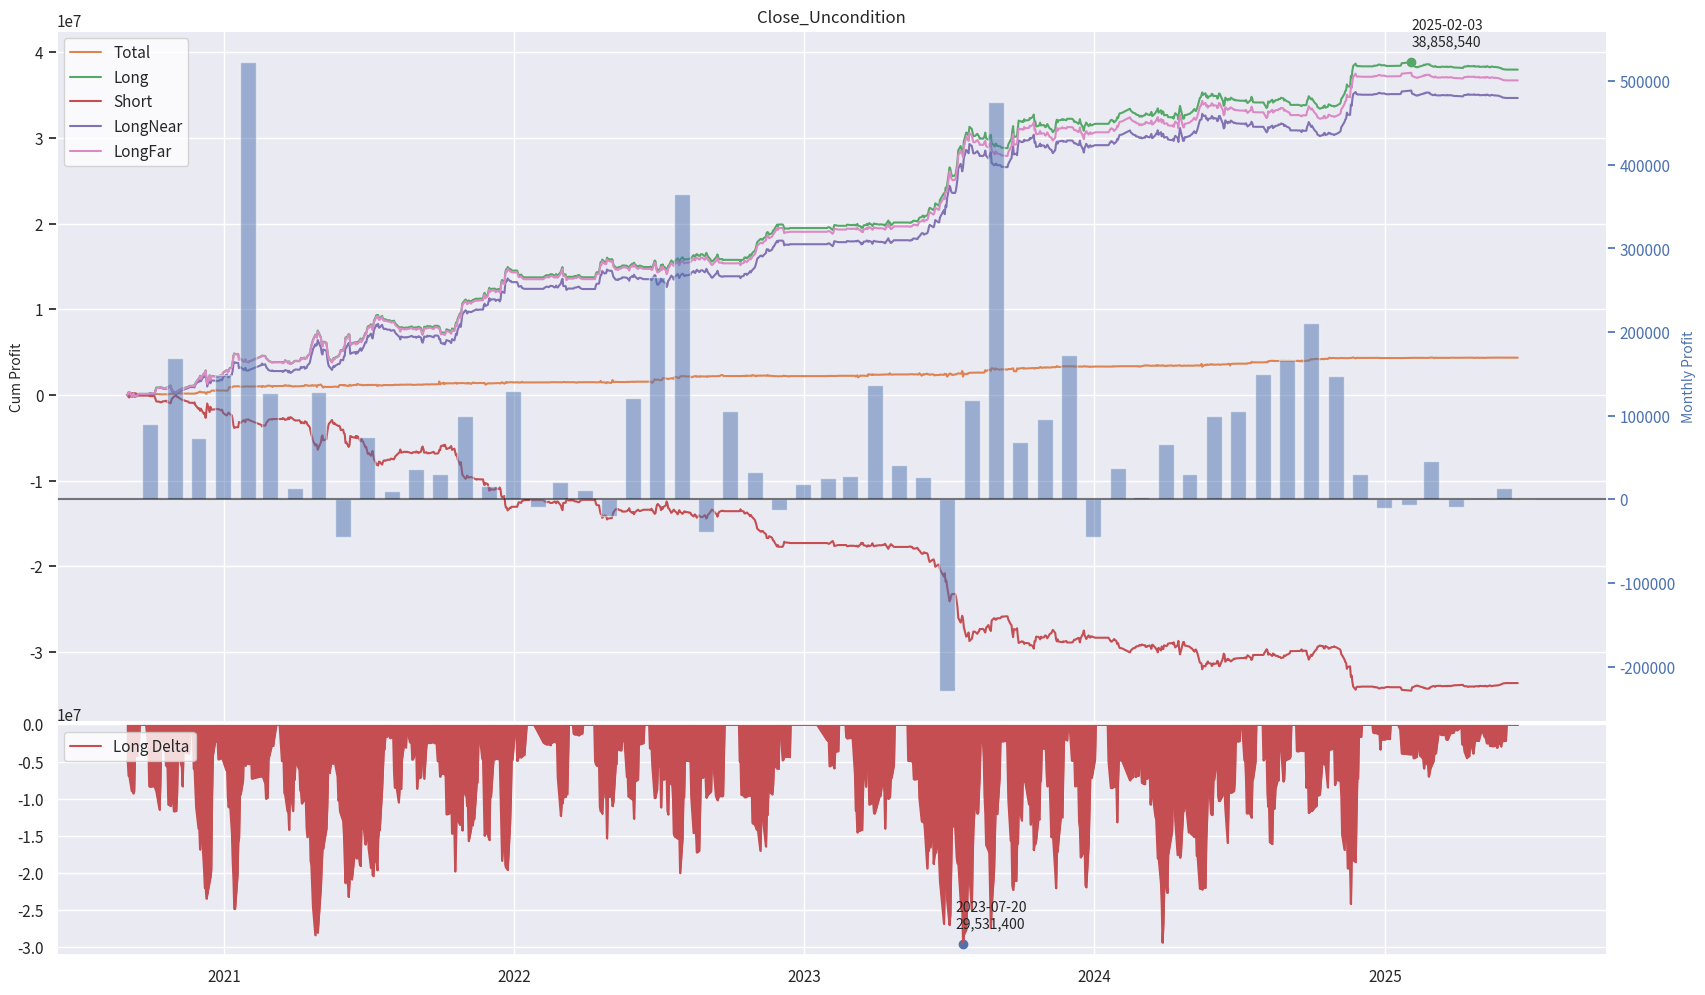

,Total,LongOnly,ShortOnly,LongNear,LongFar
Trades,533,533,533,533,533
Win Rate,56.47 %,56.29 %,43.71 %,55.35 %,56.10 %
PL Ratio(Trade),2.7141,1.7375,0.6305,1.6848,1.7033
Expectation(Trade),1.0974,0.5408,-0.2872,0.4859,0.5165
Max Profit(Trade),263904,1793448,903696,1775048,1793448
Max Loss(Trade),-108144,-906936,-1776152,-905304,-906936
Win Rate(Daily),42.30 %,44.63 %,37.75 %,44.97 %,44.80 %
PL Ratio(Daily),-0.8253,-0.7246,-1.1425,-0.7596,-0.7382
Expectation(Daily),-0.9261,-0.8771,-1.0538,-0.8919,-0.8827
Max MDD,-673956,-3679016,-34755816,-3489656,-3671416


100%|██████████| 2760/2760 [00:06<00:00, 408.21it/s]


遠月進場次數:50,近月進場次數:24
Close
1320564.0000000002 3000876.000000001 -1680312.0000000012 2259231.999999999 2814592.000000001
Long Short Ratio : 2:1
Monthly mean earning : 18,127.93
Month Max Profit : 348,424.00 , Date : 2023-08 
Month Min Profit : -214,888.00 , Date : 2023-06 
Times of Stoploss :0 (0.0 %) 


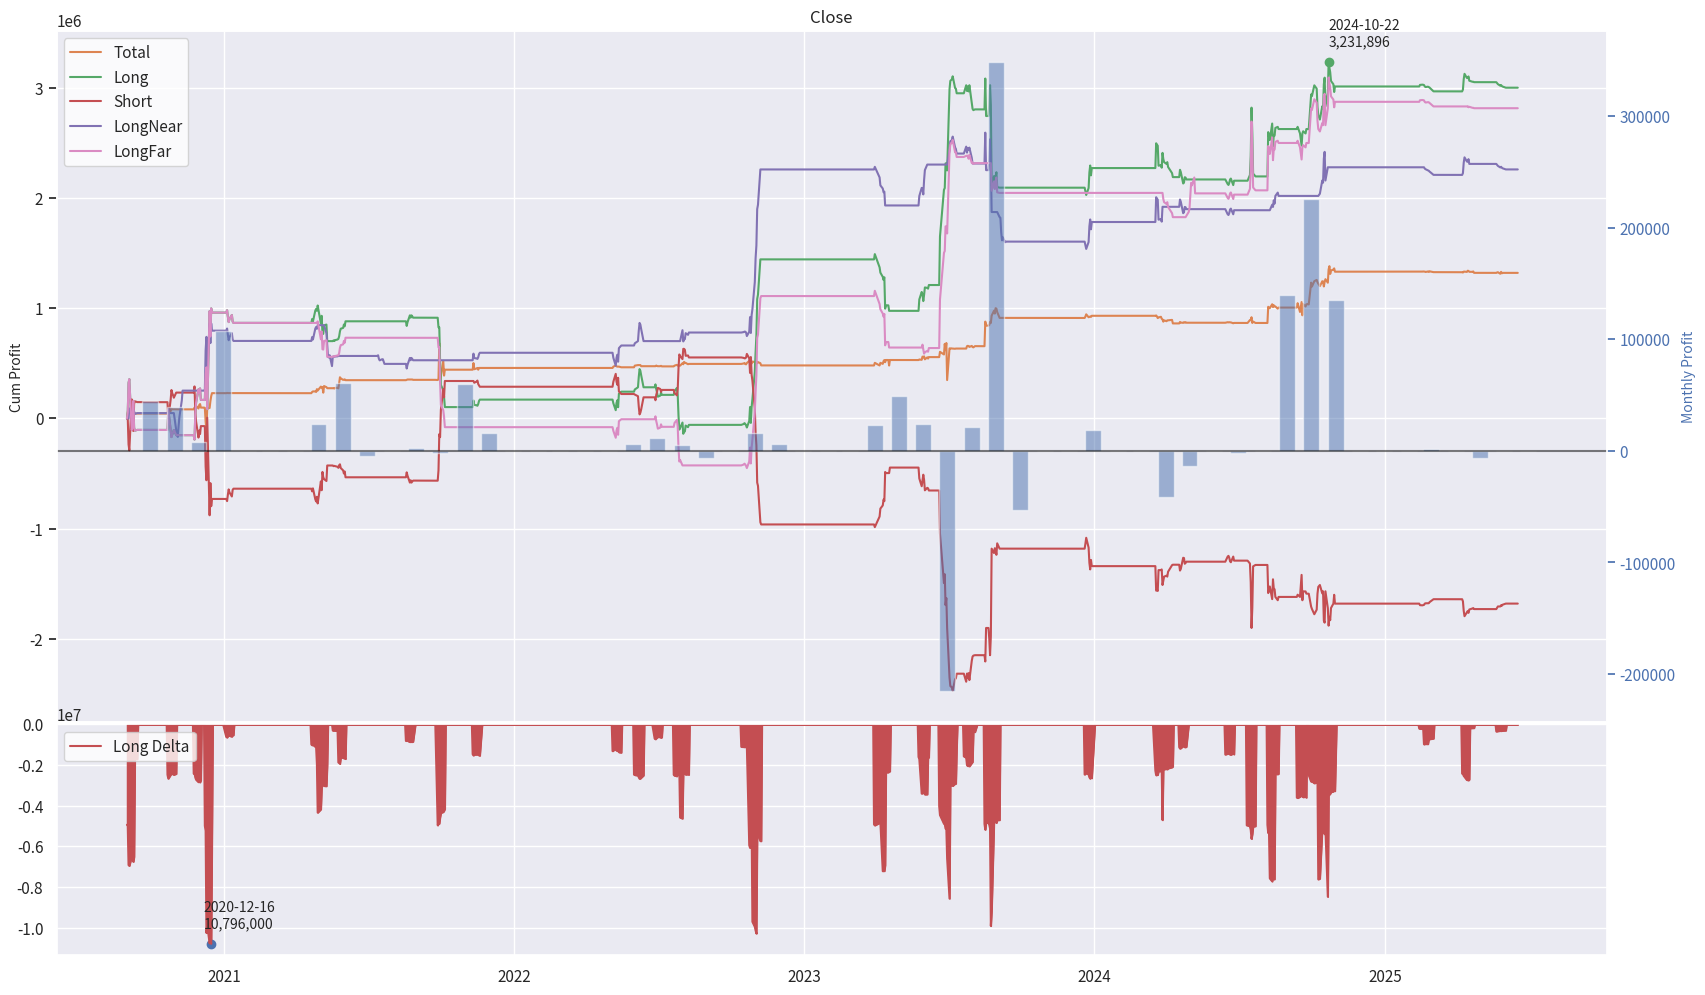

,Total,LongOnly,ShortOnly,LongNear,LongFar
Trades,55,55,55,35,41
Win Rate,74.55 %,54.55 %,47.27 %,60.00 %,51.22 %
PL Ratio(Trade),3.9921,1.5167,0.8050,1.5114,1.8326
Expectation(Trade),2.7214,0.3727,-0.1467,0.5068,0.4508
Max Profit(Trade),186532,1639952,903696,1069940,1639952
Max Loss(Trade),-36096,-811504,-1568048,-440240,-811504
Win Rate(Daily),12.04 %,12.47 %,11.78 %,9.03 %,9.97 %
PL Ratio(Daily),-0.6080,-0.6468,-0.8776,-0.5731,-0.6464
Expectation(Daily),-0.9528,-0.9560,-0.9856,-0.9615,-0.9647
Max MDD,-336192,-1163900,-3101460,-1054980,-1448832


100%|██████████| 2760/2760 [00:09<00:00, 292.81it/s]


遠月進場次數:576,近月進場次數:196
Open
-768863.9999999987 15760976.0 -16529840.0 16670884.0 15504560.0
Long Short Ratio : 2:1
Monthly mean earning : -15,784.62
Month Max Profit : 247,744.00 , Date : 2021-02 
Month Min Profit : -258,680.00 , Date : 2021-07 
Times of Stoploss :0 (0.0 %) 


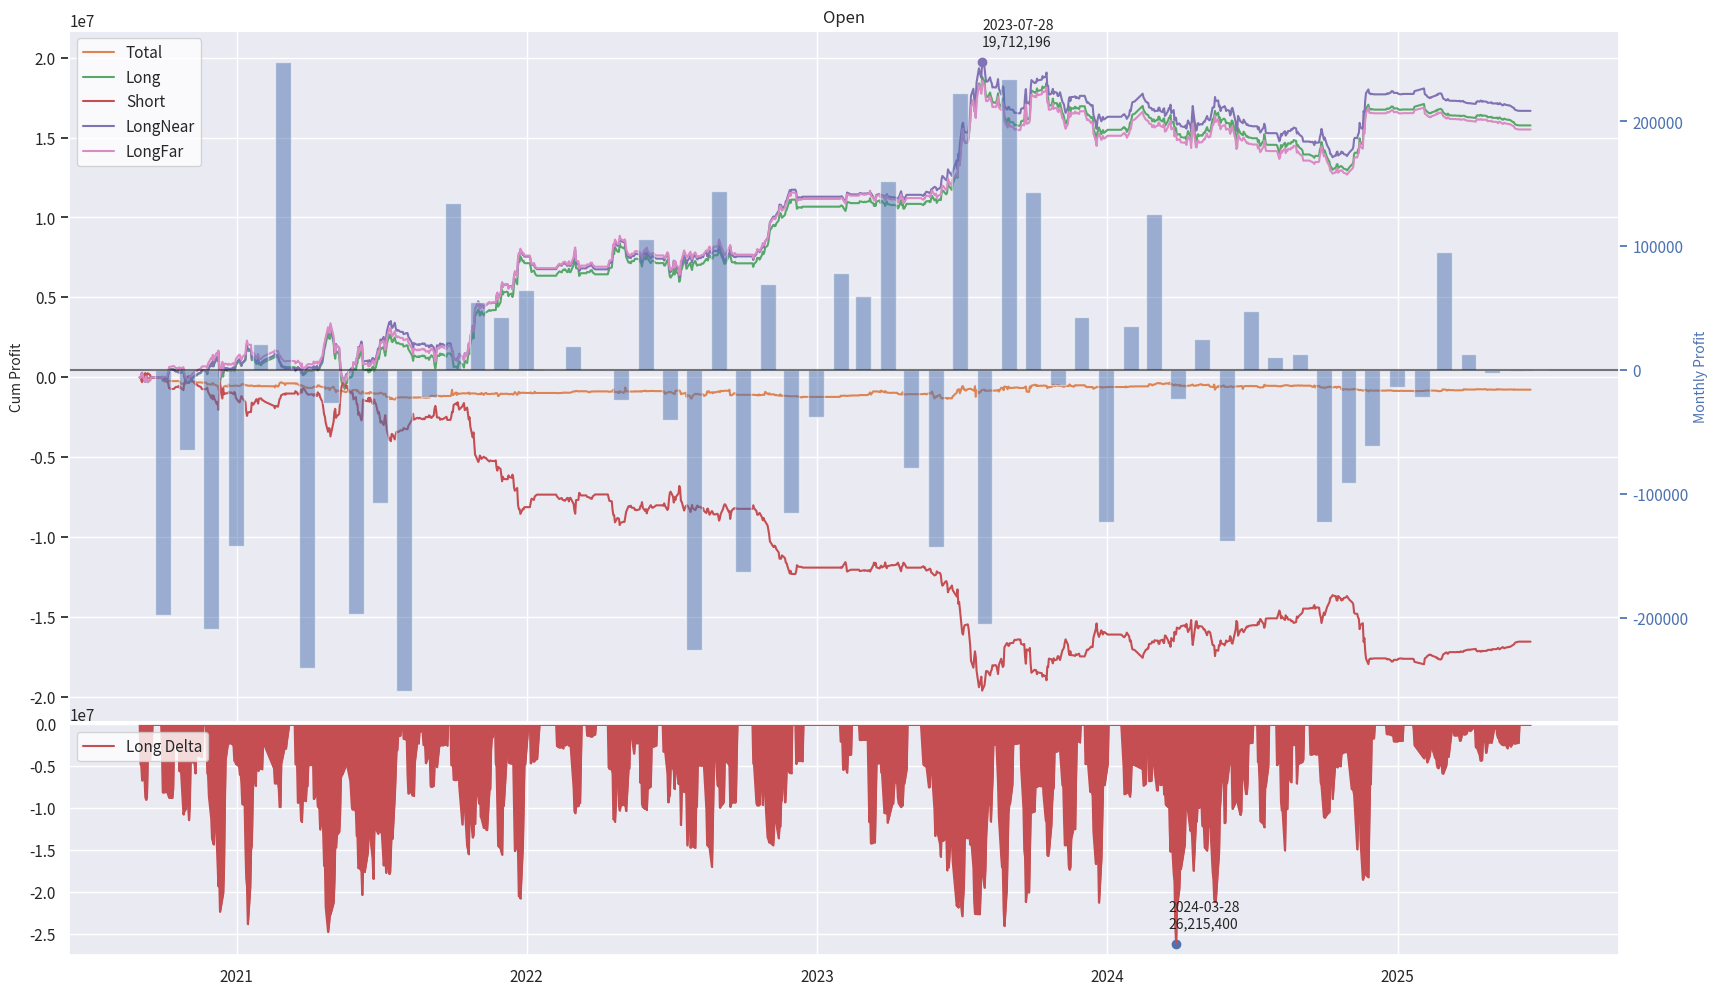

,Total,LongOnly,ShortOnly,LongNear,LongFar
Trades,534,534,534,535,534
Win Rate,41.20 %,47.75 %,49.06 %,49.72 %,48.13 %
PL Ratio(Trade),1.2830,1.5428,0.7215,1.4549,1.5153
Expectation(Trade),-0.0595,0.2143,-0.1554,0.2206,0.2106
Max Profit(Trade),255904,1633772,982608,1633772,1427472
Max Loss(Trade),-385324,-957424,-1442928,-984192,-957424
Win Rate(Daily),40.53 %,42.39 %,39.29 %,43.08 %,42.73 %
PL Ratio(Daily),-1.0590,-0.8668,-1.0840,-0.8870,-0.8830
Expectation(Daily),-1.0239,-0.9435,-1.0330,-0.9513,-0.9500
Max MDD,-1388780,-5860856,-19869224,-5947680,-5865556


100%|██████████| 2760/2760 [00:12<00:00, 228.18it/s]


遠月進場次數:576,近月進場次數:196
Mix
644848.0000000013 18230660.0 -17585812.0 17192856.0 17775300.0
Long Short Ratio : 2:1
Monthly mean earning : 9,322.62
Month Max Profit : 513,944.00 , Date : 2023-08 
Month Min Profit : -258,680.00 , Date : 2021-07 
Times of Stoploss :0 (0.0 %) 


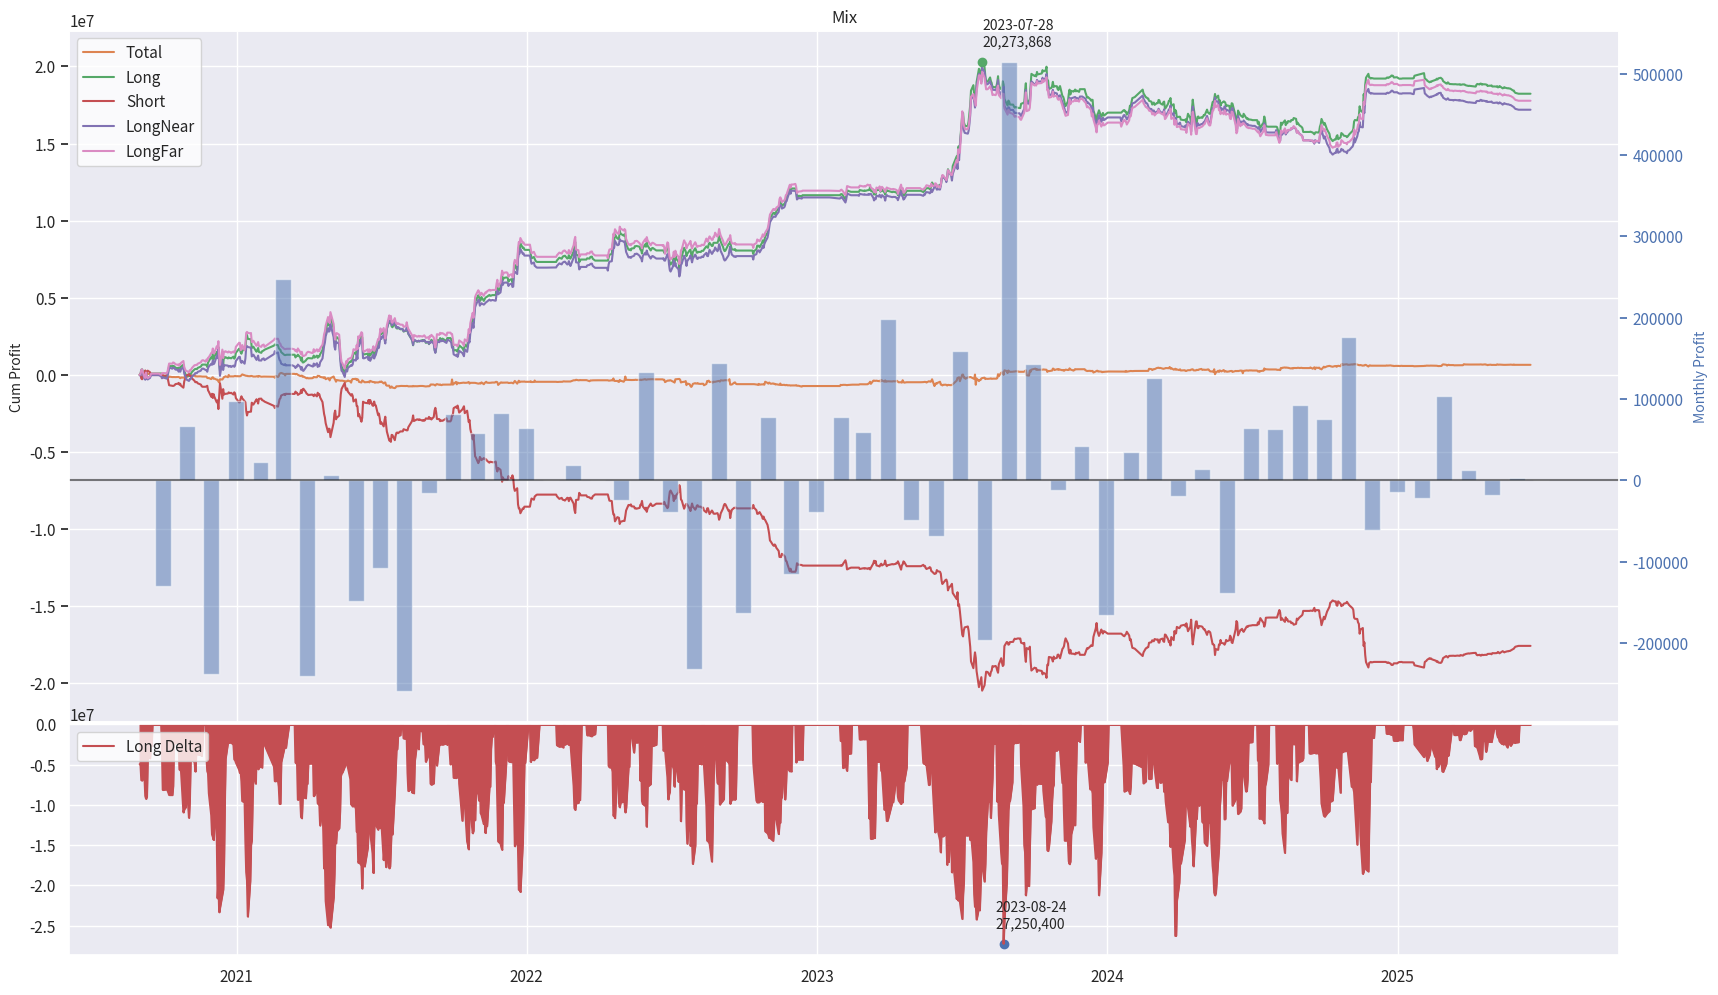

,Total,LongOnly,ShortOnly,LongNear,LongFar
Trades,534,534,534,535,534
Win Rate,44.57 %,48.31 %,48.88 %,80.56 %,75.84 %
PL Ratio(Trade),1.3604,1.5921,0.7116,2.5850,2.1847
Expectation(Trade),0.0520,0.2524,-0.1635,1.8881,1.4154
Max Profit(Trade),255904,1639952,924976,2013972,1958772
Max Loss(Trade),-385324,-957424,-1568048,-702108,-811504
Win Rate(Daily),40.84 %,42.73 %,39.12 %,42.65 %,42.73 %
PL Ratio(Daily),-0.9966,-0.8544,-1.0852,-0.8224,-0.8210
Expectation(Daily),-0.9986,-0.9378,-1.0333,-0.9243,-0.9235
Max MDD,-991120,-5113576,-20770544,-5628208,-4924368


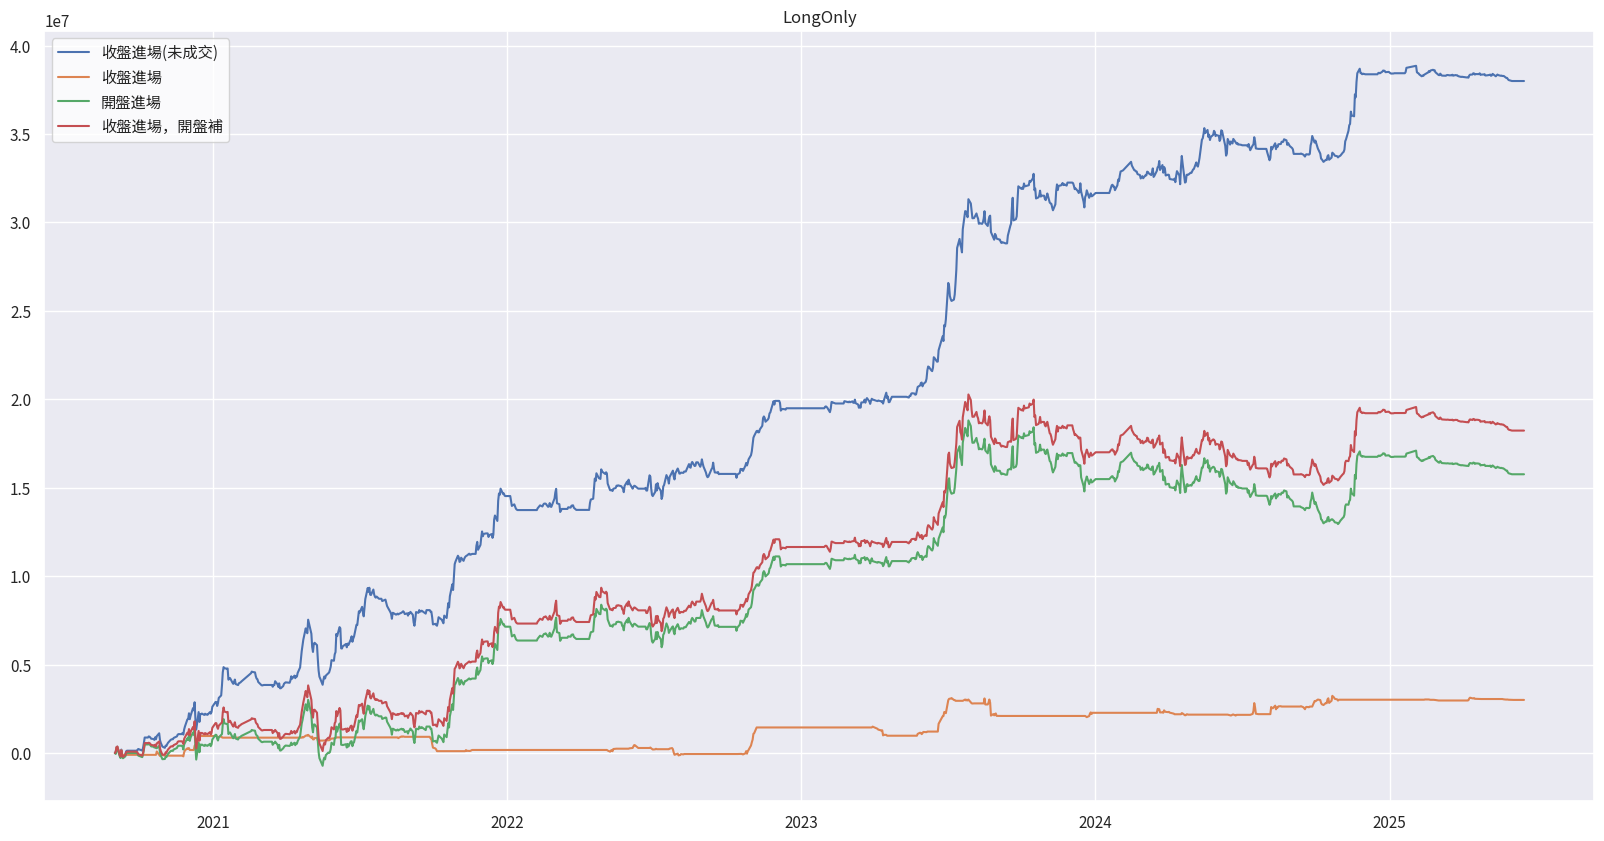

In [26]:
n=7
mix_title='LongOnly'
# ways = ['Close_Uncondition']
ways = ['Close_Uncondition','Close','Open','Mix']
df_mix = pd.DataFrame()
for w in ways:
    df_profit,df_delta,df_long,df_short,df_profit_longnear,df_profit_longfar,df_bytrade_total,df_bytrade_long,df_bytrade_short,df_bytrade_longnear,df_bytrade_longfar,stoploss_times= backtest(n,w,2,1)
    month_start = df_profit.groupby(pd.Grouper(freq='MS'))['Profit'].first()
    month_start.index = month_start.index.to_period('M')
    month_end = df_profit.groupby(pd.Grouper(freq='ME'))['Profit'].last()
    month_end.index = month_end.index.to_period('M')
    df_month = month_end - month_start
    df_month.index = df_profit.groupby(pd.Grouper(freq='ME'))['Profit'].last().index
    print(w)
    print(df_profit['Profit'][-1],df_long['LongOnly'][-1],df_short['ShortOnly'][-1],df_profit_longnear['LongNear'][-1],df_profit_longfar['LongFar'][-1])
    print(f'Long Short Ratio : 2:1')
    print(f"Monthly mean earning : {round(df_month.mean(),2):,.2f}")
    print(f'Month Max Profit : {round(df_month.max(),2):,.2f} , Date : {str(df_month[df_month==df_month.max()].index.values[0])[:7]} ')
    print(f'Month Min Profit : {round(df_month.min(),2):,.2f} , Date : {str(df_month[df_month==df_month.min()].index.values[0])[:7]} ')
    print(f'Times of Stoploss :{stoploss_times} ({stoploss_times/len(df_bytrade_total)*100} %) ')

    fig,ax1 = plt.subplots(2,figsize=(20,12),sharex=True,gridspec_kw={'height_ratios': [3,1]})
    fig.subplots_adjust(hspace = 0.005)
    ax1[0].set_title(w)
    ax2 = ax1[0].twinx()
    ax1[0].plot(df_profit['Profit'],label='Total',color='C01')
    ax1[0].plot(df_long['LongOnly'],label='Long',color='C02')
    ax1[0].plot(df_short['ShortOnly'],label='Short',color='C03')
    ax1[0].plot(df_profit_longnear['LongNear'],label='LongNear',color='C04')
    ax1[0].plot(df_profit_longfar['LongFar'],label='LongFar',color='C06')
    ax1[0].set_ylabel('Cum Profit',fontsize=10)
    ax1[0].legend(loc='upper left',facecolor='white')
    max_cumprofit = max(df_profit['Profit'].max(),df_long['LongOnly'].max(),df_short['ShortOnly'].max(),df_profit_longnear['LongNear'].max(),df_profit_longfar['LongFar'].max())
    if max_cumprofit==df_profit['Profit'].max():
        max_date = df_profit[df_profit['Profit']==df_profit['Profit'].max()].index[-1]
        ax1[0].scatter(max_date,max_cumprofit,color='C01')
        ax1[0].text(max_date,max_cumprofit,str(max_date)[:10]+f"\n{max_cumprofit:,.0f}\n",fontsize=10)
    elif max_cumprofit==df_long['LongOnly'].max():
        max_date = df_long[df_long['LongOnly']==df_long['LongOnly'].max()].index[-1]
        ax1[0].scatter(max_date,max_cumprofit,color='C02')
        ax1[0].text(max_date,max_cumprofit,str(max_date)[:10]+f"\n{max_cumprofit:,.0f}\n",fontsize=10)
    elif max_cumprofit==df_short['ShortOnly'].max():
        max_date = df_short[df_short['ShortOnly']==df_short['ShortOnly'].max()].index[-1]
        ax1[0].scatter(max_date,max_cumprofit,color='C03')
        ax1[0].text(max_date,max_cumprofit,str(max_date)[:10]+f"\n{max_cumprofit:,.0f}\n",fontsize=10)
    elif max_cumprofit==df_profit_longnear['LongNear'].max():
        max_date = df_profit_longnear[df_profit_longnear['LongNear']==df_profit_longnear['LongNear'].max()].index[-1]
        ax1[0].scatter(max_date,max_cumprofit,color='C04')
        ax1[0].text(max_date,max_cumprofit,str(max_date)[:10]+f"\n{max_cumprofit:,.0f}\n",fontsize=10)
    else:
        max_date = df_profit_longfar[df_profit_longfar['LongFar']==df_profit_longfar['LongFar'].max()].index[-1]
        ax1[0].scatter(max_date,max_cumprofit,color='C06')
        ax1[0].text(max_date,max_cumprofit,str(max_date)[:10]+f"\n{max_cumprofit:,.0f}\n",fontsize=10)

    ax2.set_ylabel('Monthly Profit',fontsize=10,color='C10')
    ax2.grid(False)
    ax2.tick_params(axis='y', colors='C10')
    ax2.axhline(0,color='Black',alpha=0.5)
    ax2.bar(df_month.index,df_month,width=20,alpha=0.5,color='C10')


    ax1[1].plot(df_delta.index,-df_delta['Delta'],label='Long Delta',color='C03')
    ax1[1].set_ylim(top=0)
    ax1[1].fill_between(df_delta.index,-df_delta['Delta'],color='C03')
    ax1[1].legend(loc='upper left',facecolor='white')
    ax1[1].scatter(df_delta[df_delta['Delta']==df_delta['Delta'].max()].index[-1],-df_delta['Delta'].max())
    delta_max = df_delta['Delta'].max()
    ax1[1].text(df_delta[df_delta['Delta']==delta_max].index[-1]-pd.Timedelta(days=10),-delta_max,str(df_delta[df_delta['Delta']==delta_max].index[-1])[:10]+f'\n{delta_max:,.0f}\n',fontsize=10)
    plt.show()
    
    display(make_result_box(df_profit,df_long,df_short,df_profit_longnear,df_profit_longfar,df_bytrade_total,df_bytrade_long,df_bytrade_short,df_bytrade_longnear,df_bytrade_longfar))
    if mix_title =='Total':
        df_mix[w]= df_profit['Profit']
    elif mix_title=='LongOnly':
        df_mix[w] = df_long['LongOnly']
    elif mix_title=='ShortOnly':
        df_mix[w]== df_short['ShortOnly']
    elif mix_title=='LongNear':
        df_mix[w] ==df_profit_longnear['LongNear']
    else:
        df_mix[w]==df_profit_longfar['LongFar']

plt.figure(figsize=(20,10))
plt.title(mix_title)
if 'Close_Uncondition' in ways:
    plt.plot(df_mix['Close_Uncondition'],label='收盤進場(未成交)')
if 'Close' in ways:
    plt.plot(df_mix['Close'],label='收盤進場')
if 'Open' in ways:
    plt.plot(df_mix['Open'],label='開盤進場')
if 'Mix' in ways:
    plt.plot(df_mix['Mix'],label='收盤進場，開盤補')
plt.legend(loc='upper left',facecolor='white') 

plt.show()  

### **股期波動度**
- 波動度計算 : ( H-L ) / O

In [21]:
df_future['近月波動'] = ((df_future['近月最高價']- df_future['近月最低價'])/ df_future['近月開盤價'])*100
df_future['近月方向'] = ((df_future['近月收盤價']- df_future['近月開盤價'])/ df_future['近月開盤價'])*100
df_future['近月方向比'] = df_future['近月方向']/df_future['近月波動']*100
df_future

,代號,名稱,近月開盤價,近月最高價,近月最低價,近月收盤價,遠月開盤價,遠月最高價,遠月最低價,遠月收盤價,前日遠月收盤價,前日近月收盤價,近月停損,遠月停損,Gap,股票代號,近月波動,近月方向,近月方向比
日期,,,,,,,,,,,,,,,,,,,
2020-01-03,GCF,鴻準,66.9,67.20,66.40,66.80,66.7,67.0,66.40,66.40,66.50,66.60,58.000,58.000,0.005988,2354.0,1.195815,-0.149477,-12.500000
2020-01-03,GHF,技嘉,50.2,50.40,49.60,49.95,50.2,50.4,49.80,49.90,49.95,50.20,7.808,7.792,0.001001,2376.0,1.593625,-0.498008,-31.250000
2020-01-03,GIF,微星,89.3,90.50,88.20,89.30,90.3,90.3,88.10,88.90,88.90,89.10,18.320,18.320,0.004479,2377.0,2.575588,0.000000,0.000000
2020-01-03,GNF,凌陽,13.7,13.70,13.20,13.35,13.7,13.7,13.30,13.35,13.80,13.80,16.600,16.600,0.000000,2401.0,3.649635,-2.554745,-70.000000
2020-01-03,GLF,正崴,46.1,46.15,44.75,45.60,46.0,46.0,44.65,45.50,45.95,46.15,139.200,140.000,0.002193,2392.0,3.036876,-1.084599,-35.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-02,PRF,宏捷科,76.3,77.50,73.30,74.00,74.0,74.0,74.00,74.00,77.30,77.30,602.400,600.000,0.000000,8086.0,5.504587,-3.014417,-54.761905
2025-06-02,PSF,神達,58.2,59.40,57.30,59.30,57.4,59.2,57.40,58.90,59.90,59.80,29.520,28.960,0.006745,3706.0,3.608247,1.890034,52.380952
2025-06-02,PTF,雙鴻,558.0,560.00,547.00,558.00,568.0,568.0,568.00,568.00,563.00,569.00,16.280,16.240,-0.017921,3324.0,2.329749,0.000000,0.000000


  0%|          | 0/1712 [00:00<?, ?it/s]

100%|██████████| 1712/1712 [00:04<00:00, 373.17it/s]


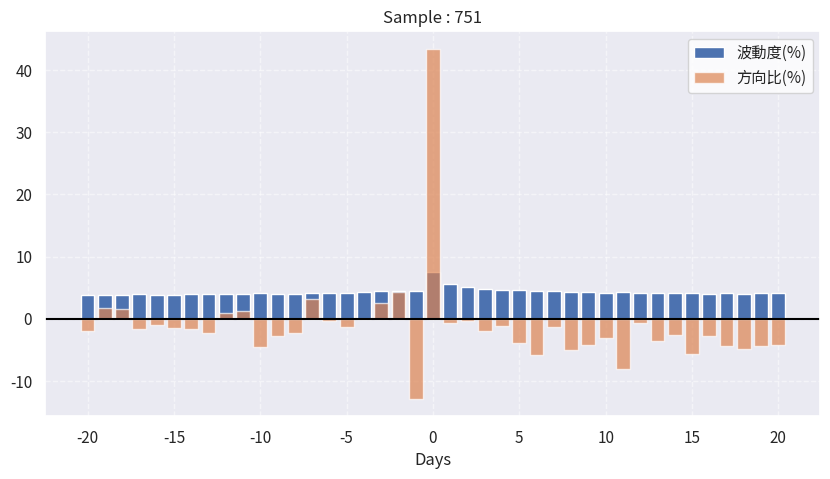

In [22]:
backward_days = 20
forward_days = 20
df_pick = data[(data['Beta']>0)&(data['週轉率(%)']>2)&(abs(data['個股變化率'])>0.05)&(data['均張變動(%)']>10)]
df_event_result1 = pd.DataFrame(index=list(range(-backward_days,forward_days+1)))
df_event_result2 = pd.DataFrame(index=list(range(-backward_days,forward_days+1)))
for i in tqdm(range(len(df_pick))):
    row = df_pick.iloc[i]
    stock = row['股票代號']
    date = row.name
    if marketdates.index(date)>=backward_days and marketdates.index(date)+forward_days<len(marketdates):
        start_date = marketdates[marketdates.index(date)-backward_days]
        end_date = marketdates[marketdates.index(date)+forward_days]
        window1 = df_future.loc[(df_future['股票代號']==stock)&(df_future.index>=start_date)&(df_future.index<=end_date)]['近月波動'].values
        window2 = df_future.loc[(df_future['股票代號']==stock)&(df_future.index>=start_date)&(df_future.index<=end_date)]['近月方向比'].values
        if len(window1)==(forward_days+backward_days+1):
            df_event_result1[i] = window1
            df_event_result2[i] = window2
df_event_result1['Mean'] = df_event_result1.mean(axis=1)
df_event_result2['Mean'] = df_event_result2.mean(axis=1)
plt.figure(figsize=(10,5))
plt.title(f'Sample : {len(df_event_result1.columns[:-1])}')
plt.xlabel('Days')
# plt.tick_params(axis='y', colors='C10')
plt.grid(True,alpha=0.5,linestyle = '--')
plt.bar(df_event_result1.index,df_event_result1['Mean'],label='波動度(%)',color='C10')
# plt.yticks(range(-2,9,1))
# plt.legend(loc='upper left',facecolor='white')
# plt.twinx()
plt.bar(df_event_result2.index,df_event_result2['Mean'],label='方向比(%)',color='C01',alpha=0.7)
plt.axhline(0,color='Black')
# plt.axvline(0,color='White')
# plt.tick_params(axis='y', colors='C01')
plt.legend(loc='upper right',facecolor='white')